In [14]:
from coffea import hist
import math
import os
import psutil
import uproot
import awkward as ak
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
import numpy as np
import random
plt.style.use(hep.style.CMS)

from matplotlib import colors
POPTS={'norm':colors.LogNorm(vmin=1,vmax=200)}

In [15]:
with uproot.open("data/protonpion_Oct1/proton_ntuple_flat_Oct1.root") as file:
    print(file["Events"].keys())
    #print(ak.to_layout(file["Events"]['Sim_Particle_kine'].array())[0:10])
    #print(ak.to_list(file["Events"]['Recoil_SimHit_layer'].array())[0:20])
    #print(ak.to_list(file["Events"]['Ecal_SimHit_layer'].array())[0:20])
    #print(ak.to_list(file["Events"]['Ecal_RecHit_layer'].array())[0:20])

    

['n_Sim_Particle', 'Sim_Particle_pdgID', 'Sim_Particle_trkID', 'Sim_Particle_mass', 'Sim_Particle_e', 'Sim_Particle_kine', 'Sim_Particle_vx', 'Sim_Particle_vy', 'Sim_Particle_vz', 'Sim_Particle_endx', 'Sim_Particle_endy', 'Sim_Particle_endz', 'Sim_Particle_px', 'Sim_Particle_py', 'Sim_Particle_pz', 'n_Recoil_SimHit', 'Recoil_SimHit_x', 'Recoil_SimHit_y', 'Recoil_SimHit_z', 'Recoil_SimHit_px', 'Recoil_SimHit_py', 'Recoil_SimHit_pz', 'Recoil_SimHit_pdgid', 'Recoil_SimHit_edep', 'Recoil_SimHit_pathLength', 'Recoil_SimHit_layer', 'n_Ecal_SimHit', 'Ecal_SimHit_edep', 'Ecal_SimHit_t', 'Ecal_SimHit_x', 'Ecal_SimHit_y', 'Ecal_SimHit_z', 'Ecal_SimHit_layer', 'n_Ecal_RecHit', 'Ecal_RecHit_amp', 'Ecal_RecHit_e', 'Ecal_RecHit_t', 'Ecal_RecHit_x', 'Ecal_RecHit_y', 'Ecal_RecHit_z', 'Ecal_RecHit_layer']
[[], [10, 9], [0, 1, 2, 3, 4, 5, 6, 7, 9, 4, 2, 5], [], [], [18], [0, 1, 2, 3, 4, 5, 6, 6, 7, 8, 12, 7, 6, 5, 7, 0, 23], [], [], [], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 

In [16]:
SimParticle_attrs = ['pdgID','trkID','mass','e','kine','vx','vy','vz','endx','endy','endz','px','py','pz']
RecoilSimHit_attrs = ['x', 'y', 'z', 'px', 'py', 'pz', 'pdgid', 'edep', 'pathLength', 'layer']
EcalSimHit_attrs = ['edep', 't', 'x', 'y', 'z', 'layer']
EcalRecHit_attrs = ['amp', 'e', 't', 'x', 'y', 'z', 'layer']


branches = {
    "Sim_Particle": SimParticle_attrs,
    "Recoil_SimHit": RecoilSimHit_attrs,
    "Ecal_SimHit": EcalSimHit_attrs,
    "Ecal_RecHit": EcalRecHit_attrs,
    "n": ["Sim_Particle", "Recoil_SimHit", "Ecal_SimHit", "Ecal_RecHit"]
}

def getData(fnames="", treeName="Events", chunks=False):
    branchlist = []
    for collection, attrs in branches.items():
        branchlist += [collection+"_"+attr for attr in attrs]
    if chunks: ldmx_dict = uproot.iterate(fnames+":"+treeName, branchlist)
    else: ldmx_dict = uproot.lazy(fnames+":"+treeName, branchlist)
    return ldmx_dict

#Repackages ldmx_dict into new dictionary of dictionaries of form
#ldmx_events={Sim_particle: {pdgID:___, trkID:___,...}, Ecal_RecHit: {amp:___, e:___, ...}, ...}
def repackage(ldmx_dict):
    evt_dict={}
    for collection in branches:    
        coll_dict={}
        for attr in branches[collection]:
            bname = "{}_{}".format(collection, attr)
            coll_dict[attr] = ldmx_dict[bname]
        evt_dict[collection] = ak.zip(coll_dict)        
    ldmx_events = ak.zip(evt_dict, depth_limit=1)
    return ldmx_events


def flat(x,axis=None): # for now must cast while waiting for coffea to catch up
    try:
        return ak.to_numpy(ak.flatten(x,axis=axis)) 
    except:
        return x

#getting rid of hits that occur at later times and earlier layers and looking at path length
#Path will only contain the first occurence of every tracker hit
def dontlookback(arr, mask=[[],[]], Start=0):
    if not ak.any(mask): mask=[[True for y in x] for x in arr]#[[True for j in i] if ak.any(i) else [False for j in i] for i in arr]
    Path=[]
    for evt1, evt2 in zip(arr, mask):
        mx=Start
        eventMask=[]
        for hit1, hit2 in zip(evt1, evt2):
            if hit1<=mx: hit2=False
            elif hit1>mx: mx=hit1
            eventMask.append(hit2)
        
        if not any(eventMask): eventMask[0]=True 
        Path.append(eventMask)
    return ak.Array(Path)
  
#Take the difference between consecutive measurements
def infinitesimalish(arr, lead=0):
    rtn=[]
    for evt in arr:
        evtArr=[]
        prev=evt[0]
        for hit in evt:
            evtArr.append(prev-hit)
            prev=hit
        
        evtArr[0]=lead
        rtn.append(evtArr)
    return ak.Array(rtn)
        
def wifMap(layerArr, zArr, mask, lead=0, oneIndexed=False):
    #Creates array of layer widths and positions. The layer number is the index to the respective values.
    numlay=ak.max(layerArr, axis=None)+1-oneIndexed
    layerZ=np.zeros(numlay)
    layerSpacing=np.zeros(numlay)
    layerSpacing[0]=lead
    #Populates layerZs and layerSpacing
    for evt1, evt2 in zip(layerArr[mask], zArr[mask]):
        for hit1, hit2 in zip(evt1, evt2):
            #layerZs
            if layerZ[hit1-oneIndexed]==0: layerZ[hit1-oneIndexed]=hit2
            #layerSpacing
            if layerSpacing[hit1-oneIndexed]==0 and layerZ[hit1-1-oneIndexed]!=0: layerSpacing[hit1-oneIndexed]=hit2-layerZ[hit1-1-oneIndexed]
            #Break if lists are done being filled
            if all(layerSpacing!=0): break    
        if all(layerSpacing!=0): break
            
    #Creates 2D array of layer widths, with same shape as layerArr, to calculate dE/dz
    WidthMap=[]
    for evt in layerArr:
        evtMask=[]
        for hit in evt:
            evtMask.append(layerSpacing[hit-oneIndexed])
        WidthMap.append(evtMask)
    
    WidthMap=ak.Array(WidthMap)
    
    return WidthMap, layerZ, layerSpacing
    

#---------------------------------- Histogram Functions---------------------------------------------------
Bins={"Sim_Particle": 
        {'pdgID':[50, 200, 2240], 'trkID':[50, 0, 100], 'mass':[20, 0, 940], 'e':[50, 2000, 3500],
         'kine':[20, 100, 2001], 'px':[50, 0, 20], 'py':[50, 0, 20], 'pz':[50, 2000, 3000],
         'endx':[50, 0, 150],'endy':[50, 0, 150], 'endz':[100, 0, 2000], 'vx':[50, 0, 10],
         'vy':[50, 0, 40], 'vz':[50, 0, 50]},
      
      "Recoil_SimHit": {'x':[50,0, 200], 'y':[50,0, 100], 'z':[50,0, 200], 'px':[50,0, 300],
                      'py':[50,0, 400], 'pz':[100,0, 300], 'pdgid':[100,0, 2500], 'edep':[50,0, 0.4],
                      'pathLength':[50,0, 1.2], 'layer':[10,0, 10]},
    
      "Ecal_SimHit": {'edep':[50, 0, 1], 't':[50, 0, 1400], 'x':[50, 0, 300],
                     'y':[50, 0, 300], 'z':[50, 200, 700], 'layer':[35, 0, 34]},
      
      "Ecal_RecHit": 
        {'amp':[50, 0, 3.6], 'e':[50, 0, 100], 't':[20, 0, 1], 
         'x':[50, 0, 250], 'y':[50, 0, 260], 'z':[50, 200, 700], 'layer':[35, 0, 34]},
      
      "n":
        {"Sim_Particle":[50, 0, 100], "Recoil_SimHit":[50, 0, 100], 
         'Ecal_SimHit':[50, 0, 90], 'Ecal_RecHit':[50, 0, 80]}
     } 

Labels={"Sim_Particle": 
        {'pdgID':'pdgID', 'trkID':'trkID', 'mass':"Mass [MeV]", 'e':"Energy [MeV]",
         'kine':"Kinetic Energy [MeV]", 'px':r"$p_x$ [MeV]", 'py':r"$p_y$ [MeV]", 'pz':r"$p_z$ [MeV]",
         'endx':r"$End_x$ [mm]",'endy':r"$End_y$ [mm]", 'endz':r"$End_z$ [mm]", 'vx':r"$v_x$ [mm]",
         'vy':r"$v_y$ [mm]", 'vz':r"$v_z$ [mm]"},
        
      "Recoil_SimHit": {'x':'x of Hit [mm]', 'y':'y of Hit [mm]', 'z':'z of Hit [mm]', 'px':'x Momentum of Hit [mm]',
                      'py':'y Momentum of Hit [mm]', 'pz':'z Momentum of Hit [mm]', 'pdgid':'pdgID', 
                      'edep':'Energy Deposited [MeV]', 'pathLength':'Path Length [mm]', 'layer':'Layer'},
    
      "Ecal_SimHit": {'edep':"Energy Deposited [MeV]", 't':"Time of Hit [ns]", 'x':'x of Hit [mm]',
                     'y':'y of Hit [mm]', 'z':'z of Hit [mm]', 'layer':'Layer'},
    
      "Ecal_RecHit": 
        {'amp':"Amplitude [mA]", 'e':"Energy [MeV]", 't':"Time [s]           ", 
         'x': "x [mm]", 'y':"y [mm]", 'z':"z [mm]", 'layer':"Layer"},
        
      "n":
        {'Sim_Particle':("Number of Hits in Event", "Sim_Particle"),
         'Recoil_SimHit':("Number of Hits in Event", "Recoil_SimHit"),   
         'Ecal_RecHit':("Number of Hits in Event", "Ecal_RecHit"),
         'Ecal_SimHit':("Number of Hits in Event", "Ecal_SimHit")} 
         }



#Makes Dictionary of hist.Hist objects in same layout as ldmx_events, where each attr. becomes a key.
#AttrDict must be a dictionary. Bin layout is determined by Bins 3d array, which is indexed with BinAttr
#and BinKey. Preferably this will be mapped out so that individual histograms may be additioned to attr.
#keys. and/or separate binning may be provided. 
def MakeHists(AttrDict, Bins):
    hists={}
    for coll in AttrDict.keys():
        attrHists={}
        for attr in AttrDict[coll]:
            attrHists[attr]=hist.Hist(coll, 
                    axes=(
                    hist.Cat("particle", "Particle"),
                    hist.Bin("e", attr, *(Bins[coll][attr]))
                    ))
            
        hists[coll]=attrHists
    return hists

#def FillHists

In [17]:
hists=MakeHists(branches, Bins)

histsAdd={}


In [18]:
#-----------------------------------------------------------------------------------------------------------------------
#----------------------------------- Additional Histograms -------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------- 

#-----------Recoil_SimHit
histsAdd["recoil_dedzKine"]=hist.Hist("Recoil_SimHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "dE/dZ", 100, 0, 0.2),
                            hist.Bin("s", "Kine",100, 100, 2001)))

histsAdd["recoil_dedzMIPKine"]=hist.Hist("Recoil_SimHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "dE/dZ", 100, 0, 0.2),
                            hist.Bin("s", "Kine",100, 100, 2001)))

histsAdd["recoil_KineLayer"]=hist.Hist("Ecal_SimHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Layer", 10, 1, 11),
                            hist.Bin("s", "Kine",100, 100, 2001)))

#-----------Ecal_SimHit
histsAdd["ecalSim_dedzKine"]=hist.Hist("Ecal_SimHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "dE/dZ", 100, 0, 0.2),
                            hist.Bin("s", "Kine",100, 100, 2001)))

histsAdd["ecalSim_dedzMIPKine"]=hist.Hist("Ecal_SimHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "dE/dZ", 100, 0, 0.2),
                            hist.Bin("s", "Kine",100, 100, 2001)))

histsAdd["ecalSim_KineLayer"]=hist.Hist("Ecal_SimHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Layer", 34, 0, 34),
                            hist.Bin("s", "Kine",100, 100, 2001)))

#----------Ecal_RecHit
histsAdd["ecalRec_avgEKine"]=hist.Hist("Ecal_SimHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "dE/dZ", 100, 0, 100),
                            hist.Bin("s", "Kine",100, 100, 2001)))


In [19]:
def ProcessChunk(chunk, hists):
    ldmx_events = repackage(chunk)
    
    sim_particle = ldmx_events['Sim_Particle']
    recoil_simhit = ldmx_events['Recoil_SimHit']
    ecal_simhit = ldmx_events['Ecal_SimHit']
    ecal_rechit = ldmx_events['Ecal_RecHit']
    
    #print(ak.to_list(ecal_rechit.layer[0:20]),'\n',ak.to_list(ecal_rechit.e[0:20]),'\n',ak.to_list(sim_particle.kine[0:20]))


#------------------------------------------------------------------------------------------------------------    
#--------------------------------------- DATA MASKS/MANIPULATION --------------------------------------------
#------------------------------------------------------------------------------------------------------------    
    #Determines if data file is one for protons or pions
    par=""
    ID=0
    if ak.all(sim_particle.pdgID==2212):
        par="Proton"
        ID=2212
    elif ak.all(sim_particle.pdgID==211):
        par="Pion"
        ID=211
    
    
    #Fills all histograms in "hists" that are regular 1D hists of collection attributes
    for coll in ldmx_events.fields:
        for f in ldmx_events[coll].fields:
            hists[coll][f].fill(particle=par, e= flat(getattr(ldmx_events[coll], f)))
            
    #Removes empty events. There are a lot of empty events. 
    recoilEmptyMask=getattr(ldmx_events['n'], "Recoil_SimHit")!=0
    recoil_simhit=recoil_simhit[recoilEmptyMask]
    ecalEmptyMask=getattr(ldmx_events['n'], "Ecal_SimHit")!=0
    ecal_simhit=ecal_simhit[ecalEmptyMask]
    ecalRecEmptyMask=getattr(ldmx_events['n'], "Ecal_RecHit")!=0
    ecal_rechit=ecal_rechit[ecalRecEmptyMask]
    
    #pdgID Mask
    recoilIDMask=recoil_simhit.pdgid==ID
    
    #Scatter Masks
    recoilPath=dontlookback(recoil_simhit.layer, recoilIDMask)
    ecalPath=dontlookback(ecal_simhit.layer, Start=-1)
    ecalRecPath=dontlookback(ecal_rechit.layer, Start=-1)

    
    #MIP Masks
    recoilMIPMask=recoil_simhit.edep>=.13
    ecalSimMIPMask=ecal_simhit.edep>=.13
    ecalRecMIPMask=ecal_rechit.e>=.13
    
    recoilWidthMap, recoilLayerZ, recoilLayerSpacing=wifMap(recoil_simhit.layer, recoil_simhit.z, \
                                                            recoilPath, lead=9.0, oneIndexed=True)
    print(recoilWidthMap, "\n", recoilLayerZ, "\n", recoilLayerSpacing)
    ecalWidthMap, ecalLayerZ, ecalLayerSpacing=wifMap(ecal_simhit.layer, ecal_simhit.z, ecalPath, lead=10.0)
    ecalRecWidthMap, ecalRecLayerZ, ecalRecLayerSpacing=wifMap(ecal_rechit.layer, ecal_rechit.z, ecalRecPath, lead=10.0)
 
    
    #Making ecal_rechit edep. ecal_rechit edep and dedz have different shape than the record and cannot be treated as 
    #extended attributes like ecal_simhit, recoil_simhit, edep and dedz
    ecalRecEdep=infinitesimalish(ecal_rechit.e[ecalRecPath]) 
    ecalRecDedz=ecalRecEdep/ecalRecWidthMap[ecalRecPath]
    ecalRec_dedzMIPMask=ecalRecDedz>=.13/ecalRecWidthMap[ecalRecPath]
    #print(ecalRecDedz)
    
    #NEW ATTRIBUTES FOR DEDZ ADDED TO RECOIL_SIMHITS
    recoil_simhit["dedz"]=recoil_simhit.edep/recoilWidthMap
    recoil_dedzMIPMask=recoil_simhit.dedz>=.13/recoilWidthMap
    
    #NEW ATTRIBUTES FOR DEDZ ADDED TO ECAL_SIMHITS
    ecal_simhit["dedz"]=ecal_simhit.edep/ecalWidthMap
    ecal_dedzMIPMask=ecal_simhit.dedz>=.13/ecalWidthMap
    
    #Range of iteration for kinetic energy 2d plots
    kineRange=np.linspace(100,1981,100)
    
    #------------------------------------Data Anlaysis/Histogram Filling------------------------------------------------
    
    #---------------Sim Particle
    
    
    #---------------Recoil Tracker
    #'''
    for i in kineRange:
        kineMaskLower=sim_particle.kine>=i 
        kineMaskUpper=sim_particle.kine<(i+19)
        oneDMask=kineMaskLower & kineMaskUpper
        oneDMask=oneDMask[recoilEmptyMask]
        twoDMask=recoil_dedzMIPMask
        totalMask=oneDMask
        
        #Fills dedz
        dedzKine=ak.flatten(recoil_simhit.dedz[totalMask], axis=None)
        histsAdd["recoil_dedzKine"].fill(particle=par, e=dedzKine, s=i)
        
        #Fills MIP dedz
        totalMask=twoDMask[oneDMask]
        dedzKine=ak.flatten(recoil_simhit.dedz[totalMask], axis=None)
        histsAdd["recoil_dedzMIPKine"].fill(particle=par, e=dedzKine, s=i)
        
        #Fills KineLayer
        Layers=ak.flatten(recoil_simhit.layer[oneDMask], axis=None)
        histsAdd["recoil_KineLayer"].fill(particle=par, e=Layers, s=i)
        
    #'''
    #---------------Ecal_SimHits
    for i in kineRange:
        kineMaskLower=sim_particle.kine>=i 
        kineMaskUpper=sim_particle.kine<(i+19)
        oneDMask=kineMaskLower & kineMaskUpper 
        #Changes oneDMask to match ecal_simhit dimensions, since it was redefined to remove empty records
        oneDMask=oneDMask[ecalEmptyMask] 
        twoDMask=ecal_dedzMIPMask
        
        #Fills dedz
        dedzKine=ak.flatten(ecal_simhit.dedz[oneDMask], axis=None)
        histsAdd["ecalSim_dedzKine"].fill(particle=par, e=dedzKine, s=i)
        
        #Fills MIP dedz
        totalMask=twoDMask[oneDMask]
        dedzKineMip=ak.flatten(ecal_simhit.dedz[totalMask], axis=None)
        histsAdd["ecalSim_dedzMIPKine"].fill(particle=par, e=dedzKineMip, s=i)
        
        #Fills KineLayer
        Layers=ak.flatten(ecal_simhit.layer[oneDMask], axis=None)
        histsAdd["ecalSim_KineLayer"].fill(particle=par, e=Layers, s=i)
        
        
    #---------------Ecal_RecHits
    for i in kineRange:
        kineMaskLower=sim_particle.kine>=i 
        kineMaskUpper=sim_particle.kine<(i+19)
        oneDMask=kineMaskLower & kineMaskUpper
        #Changes oneDMask to match ecal_simhit dimensions, since it was redefined to remove empty records
        oneDMask=oneDMask[ecalRecEmptyMask]
        
        AvgE=ak.flatten(ak.mean(ecal_rechit.e[oneDMask], axis=1), axis=None)
        histsAdd["ecalRec_avgEKine"].fill(particle=par, e=AvgE, s=i)
        #histsAdd["ecalRec_EzKine"].fill(particle=par, e)
    
    #'''
    #------------------------------------------------------------------------------------------
    #------Recoil_SimHit z,r difference between first and last layer    
    #'''
    recoil_xdif=ak.flatten(recoil_simhit.x[recoilPath][:,-1]-recoil_simhit.x[recoilPath][:,0], axis=None)
    recoil_ydif=ak.flatten(recoil_simhit.y[recoilPath][:,-1]-recoil_simhit.y[recoilPath][:,0], axis=None)
    recoil_zdif=ak.flatten(recoil_simhit.z[recoilPath][:,-1]-recoil_simhit.z[recoilPath][:,0], axis=None)
    recoil_rdif=np.sqrt(recoil_xdif**2+recoil_ydif**2+recoil_zdif**2)
    
    #------Ecal_SimHit z, r difference between first and last layer      
    ecal_xdif=ak.flatten(ecal_simhit.x[ecalPath][:,-1]-ecal_simhit.x[ecalPath][:,0], axis=None)
    ecal_ydif=ak.flatten(ecal_simhit.y[ecalPath][:,-1]-ecal_simhit.y[ecalPath][:,0], axis=None)
    ecal_zdif=ak.flatten(ecal_simhit.z[ecalPath][:,-1]-ecal_simhit.z[ecalPath][:,0], axis=None)
    ecal_rdif=np.sqrt(ecal_xdif**2+ecal_ydif**2+ecal_zdif**2)
    
    #-------------------------- dE/dZ Whole Ecal 
    '''
    evtESum=ak.sum(ecal_simhit.edep[ecalPath], axis=1)/ecal_zdif   
    
    for i in range(0,34):
        dedzSpec=ak.flatten(ecal_simhit.dedz[ecalPath & dedzMIPMask & (ecal_simhit.layer==i)], axis=None)
        histsAdd['dE/dzSpecific'].fill(particle=par, e=dedzSpec, s=i)
    
    
    #'''
    #----------------------------------------------- MIP Averages ------------------------------------------------
    '''
    #------------Recoil
    for i in range(100, 2000.01,  ):
        LayerEdep=ak.flatten(ak.mean(recoil_simhit.edep[recoilMIPMask & (recoil_simhit.layer==i)], axis=1), axis=0)
        histsAdd["recoil_mipAvgLayer"].fill(particle=par, e=LayerEdep, s=i)
    
    #-------------Ecal_SimHit  
    for i in range(0,34):
        LayerEdep=ak.flatten(ak.mean(ecal_simhit.edep[ecalSimMIPMask & (ecal_simhit.layer==i)], axis=1), axis=0)
        histsAdd["ecalSimHit_mipAvgLayer"].fill(particle=par, e=LayerEdep, s=i)

    #-------------Ecal_RecHit 
    for i in range(0,34):
        LayerEdep=ak.flatten(ak.mean(ecal_rechit.e[ecalSimMIPMask & (ecal_rechit.layer==i)], axis=1), axis=0)
        histsAdd["ecalRecHit_mipAvgLayer"].fill(particle=par, e=LayerEdep, s=i)
      
    #'''
#--------------------------------------- HISTOGRAM FILLING -------------------------------------
    

    #'''

In [20]:
ldmx_dict_all = getData(chunks=True, fnames="data/protonpion_Oct1/*.root")

nchunk = 0
for chunk in ldmx_dict_all:
    nchunk += 1
    print('process',nchunk)
    ProcessChunk(chunk, hists)

process 1
[[9], [9], [9, 5.91, 35], [9, 5.91, ... [9, 5.91, 9.09, 6, 9, 6, 35, 90, 90, 90]] 
 [  6.9000001   12.80750751  21.89999962  27.89999962  36.90000153
  42.90000153  51.90000153  57.90000153  92.90000153 182.8999939 ] 
 [ 9.          5.90750742  9.0924921   6.          9.00000191  6.
  9.          6.         35.         89.99999237]
process 2
[[9], [9], [9, 6, 9, 6, 9, 35, 92], ... [9, 6], [9, 6, 9, 6, 9, 6, 9, 35, 92, 92]] 
 [  6.9000001   12.89999962  21.89999962  27.89999962  36.90000153
  42.90000153  51.90000153  57.90000153  90.90000153 182.8999939 ] 
 [ 9.          5.99999952  9.          6.          9.00000191  6.
  9.          6.         35.         91.99999237]


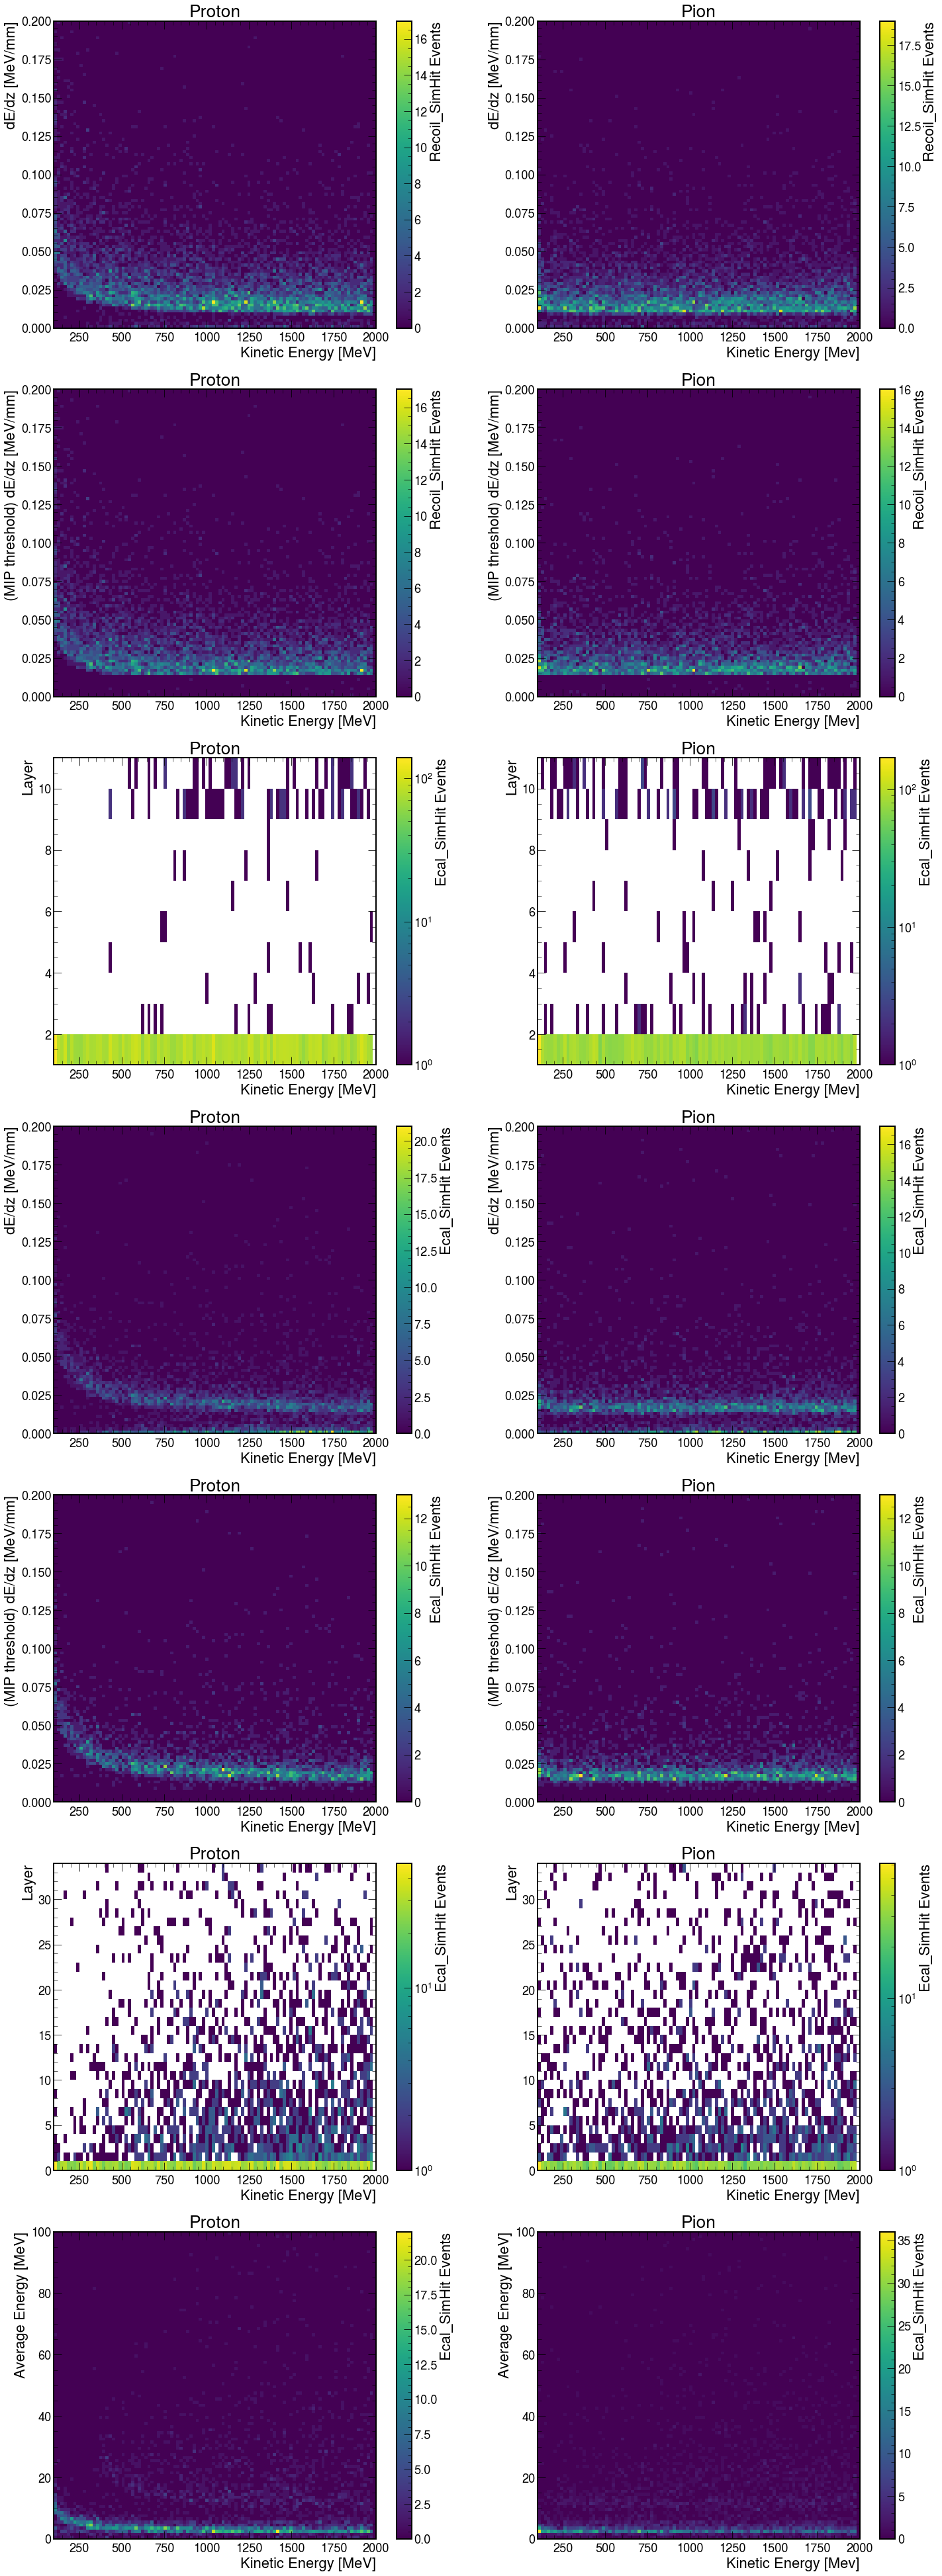

In [21]:
import ipywidgets as widgets

from matplotlib import rcParams
from matplotlib import colors
plt.rcParams.update({'font.size': 22})

#------------------------- Plot all graphs in hists --------------------------------
'''
i=0
for coll in hists.keys():
    for key in hists[coll]:
        if i%2==0:
            fig, ax=plt.subplots(ncols=2, figsize=(22,10))
        hist.plot1d(hists[coll][key], ax=ax[i%2], clear=False, overlay="particle")
        
        if (type(Labels[coll][key])==tuple):
            ax[i%2].set_xlabel(Labels[coll][key][0])
            ax[i%2].set_ylabel(Labels[coll][key][1])
        else:
            ax[i%2].set_xlabel(Labels[coll][key])
            
        i+=1
'''
#------------------------- Plotting Widget ----------------------------------------
'''
#Makes a list of attributes for the widget
widlist=[[coll+"-"+attr for attr in branches[coll]] for coll in branches.keys()]
WidList=np.array([])
for i in widlist:
    WidList=np.append(WidList, i)


fig, axW=plt.subplots(figsize=(10,10))

def plott(attr, compare=True):
    coll=attr[:attr.find("-")]
    key=attr[attr.find("-")+1:]
    hist.plot1d(hists[coll][key], ax=axW, overlay="particle", clear=compare)#, legend_opts={'labels':[attr]})
    
    if (type(Labels[coll][key])==tuple):
        axW.set_xlabel(Labels[coll][key][0], fontsize=18)
        axW.set_ylabel(Labels[coll][key][1], fontsize=18)
    else:
        axW.set_xlabel(Labels[coll][key], fontsize=18)
        axW.set_ylabel(coll, size=18)
    #plt.close()
    #display(fig)
   
    
_=widgets.interact(plott, attr=WidList, compare=[("True",0),("False",1)]);
#'''

#------------------------------------- 2D Plots ---------------------------------------------------
#'''
#--------------------------Recoil_SimHit
fig, ax=plt.subplots(ncols=2, nrows=7, figsize=(24,70))
hist.plot2d(histsAdd['recoil_dedzKine']["Proton"].sum("particle"), "s", ax=ax[0,0], clear=True)
ax[0, 0].set_xlabel("Kinetic Energy [MeV]")
ax[0, 0].set_ylabel("dE/dz [MeV/mm]")

hist.plot2d(histsAdd['recoil_dedzKine']["Pion"].sum("particle"), "s", ax=ax[0,1], clear=True)
ax[0, 1].set_xlabel("Kinetic Energy [Mev]")
ax[0, 1].set_ylabel("dE/dz [MeV/mm]")
ax[0, 0].set_title("Proton")
ax[0, 1].set_title("Pion")

hist.plot2d(histsAdd['recoil_dedzMIPKine']["Proton"].sum("particle"), "s", ax=ax[1,0], clear=True)
ax[1, 0].set_xlabel("Kinetic Energy [MeV]")
ax[1, 0].set_ylabel("(MIP threshold) dE/dz [MeV/mm]")

hist.plot2d(histsAdd['recoil_dedzMIPKine']["Pion"].sum("particle"), "s", ax=ax[1,1], clear=True)
ax[1, 1].set_xlabel("Kinetic Energy [Mev]")
ax[1, 1].set_ylabel("(MIP threshold) dE/dz [MeV/mm]")
ax[1, 0].set_title("Proton")
ax[1, 1].set_title("Pion")

hist.plot2d(histsAdd['recoil_KineLayer']["Proton"].sum("particle"), "s", ax=ax[2,0], clear=True, patch_opts={'norm': colors.LogNorm()})
ax[2, 0].set_xlabel("Kinetic Energy [MeV]")
ax[2, 0].set_ylabel("Layer")

hist.plot2d(histsAdd['recoil_KineLayer']["Pion"].sum("particle"), "s", ax=ax[2,1], clear=True, patch_opts={'norm': colors.LogNorm()})
ax[2, 1].set_xlabel("Kinetic Energy [Mev]")
ax[2, 1].set_ylabel("Layer")
ax[2, 0].set_title("Proton")
ax[2, 1].set_title("Pion")

#---------------------------Ecal_SimHit
hist.plot2d(histsAdd['ecalSim_dedzKine']["Proton"].sum("particle"), "s", ax=ax[3,0], clear=True)
ax[3, 0].set_xlabel("Kinetic Energy [MeV]")
ax[3, 0].set_ylabel("dE/dz [MeV/mm]")

hist.plot2d(histsAdd['ecalSim_dedzKine']["Pion"].sum("particle"), "s", ax=ax[3,1], clear=True)
ax[3, 1].set_xlabel("Kinetic Energy [Mev]")
ax[3, 1].set_ylabel("dE/dz [MeV/mm]")
ax[3, 0].set_title("Proton")
ax[3, 1].set_title("Pion")

hist.plot2d(histsAdd["ecalSim_dedzMIPKine"]["Proton"].sum("particle"), "s", ax=ax[4,0], clear=True)
ax[4, 0].set_xlabel("Kinetic Energy [MeV]")
ax[4, 0].set_ylabel("(MIP threshold) dE/dz [MeV/mm]")

hist.plot2d(histsAdd["ecalSim_dedzMIPKine"]["Pion"].sum("particle"), "s", ax=ax[4,1], clear=True)
ax[4, 1].set_xlabel("Kinetic Energy [Mev]")
ax[4, 1].set_ylabel("(MIP threshold) dE/dz [MeV/mm]")
ax[4, 0].set_title("Proton")
ax[4, 1].set_title("Pion")

hist.plot2d(histsAdd["ecalSim_KineLayer"]["Proton"].sum("particle"), "s", ax=ax[5,0], clear=True, patch_opts={'norm': colors.LogNorm()})
ax[5, 0].set_xlabel("Kinetic Energy [MeV]")
ax[5, 0].set_ylabel("Layer")

hist.plot2d(histsAdd["ecalSim_KineLayer"]["Pion"].sum("particle"), "s", ax=ax[5,1], clear=True, patch_opts={'norm': colors.LogNorm()})
ax[5, 1].set_xlabel("Kinetic Energy [Mev]")
ax[5, 1].set_ylabel("Layer")
ax[5, 0].set_title("Proton")
ax[5, 1].set_title("Pion")

#---------------------------Ecal_RecHit
#'''
hist.plot2d(histsAdd['ecalRec_avgEKine']["Proton"].sum("particle"), "s", ax=ax[6,0], clear=True)
ax[6, 0].set_xlabel("Kinetic Energy [MeV]")
ax[6, 0].set_ylabel("Average Energy [MeV]")

hist.plot2d(histsAdd['ecalRec_avgEKine']["Pion"].sum("particle"), "s", ax=ax[6,1], clear=True)
ax[6, 1].set_xlabel("Kinetic Energy [Mev]")
ax[6, 1].set_ylabel("Average Energy [MeV]")
ax[6, 0].set_title("Proton")
ax[6, 1].set_title("Pion")
#'''

plt.show()

In [22]:
#Creates array of ecal layer widths and positions. The layer number is the index to the respective values.
    layerZs=np.zeros(34)
    layerSpacing=np.zeros(34)
    layerSpacing[0]=10.0
    #Populates layerZs and layerSpacing
    for evt1, evt2 in zip(ecal_simhit.layer[ecalPath], ecal_simhit.z[ecalPath]):
        #In case the event starts with a layer that has not been indexed yet, use the average layer
        #prevLayer=evt1
        for hit1, hit2 in zip(evt1, evt2):
            #layerZs
            if layerZs[hit1]==0: layerZs[hit1]=hit2
            #layerSpacing
            if layerSpacing[hit1]==0 and layerZs[hit1-1]!=0: layerSpacing[hit1]=hit2-layerZs[hit1-1]
            #Break if lists are done being filled
            if layerSpacing[33]!=0: break    
        if layerSpacing[33]!=0: break
            
    #Creates 2D array of layer widths, with same shape as ecal_simhit.edep, to calculate dE/dz
    WidthMap=[]
    for evt in ecal_simhit.layer:
        evtMask=[]
        for hit in evt:
            evtMask.append(layerSpacing[hit])
        WidthMap.append(evtMask)
    
    WidthMap=ak.Array(WidthMap)

IndentationError: unexpected indent (Temp/ipykernel_11800/1330549075.py, line 2)